In [1]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from config.config import Config
from src.data_loader import DataLoader
from src.pre_processing import PreProcessor
from src.feature_extraction import FeatureExtractor
from src.cache_manager import CacheManager
from src.models import ModelFactory

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
config = Config()

FEATURE_SET = "xgb"  # baseline / xgb
TEST_SIZE = 0.2
VAL_SIZE = 0.125
RANDOM_STATE = config.RANDOM_STATE
SELECTED_MODELS = ["all"]  # all for all models or select the models to train from models.py

In [3]:
loader = DataLoader()
preprocessor = PreProcessor()
feature_extractor = FeatureExtractor(feature_set=FEATURE_SET)
cache_manager = CacheManager()
factory = ModelFactory()
#cache_manager.clear_cache()

if SELECTED_MODELS == ["all"] or (len(SELECTED_MODELS) >= 1 and SELECTED_MODELS[0] == "all"):
    SELECTED_MODELS = list(factory.get_all_models().keys())

metadata = loader.load_metadata()

In [4]:

train_val_df, test_df = train_test_split(
    metadata,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=metadata["classID"]
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=VAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=train_val_df["classID"]
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["classID"].value_counts().sort_index().to_string())

print("\nValidation class distribution:")
print(val_df["classID"].value_counts().sort_index().to_string())

print("\nTest class distribution:")
print(test_df["classID"].value_counts().sort_index().to_string())

Train size: 6111
Validation size: 874
Test size: 1747

Train class distribution:
classID
0    700
1    300
2    700
3    700
4    700
5    700
6    261
7    700
8    650
9    700

Validation class distribution:
classID
0    100
1     43
2    100
3    100
4    100
5    100
6     38
7    100
8     93
9    100

Test class distribution:
classID
0    200
1     86
2    200
3    200
4    200
5    200
6     75
7    200
8    186
9    200


In [5]:
def extract_X_Y(df, feature_set):
    X, Y = [], []

    for _, row in df.iterrows():
        audio_path = loader.get_audio_path(row["slice_file_name"], row['fold'])

        feats = cache_manager.load_cached_features(audio_path, feature_set)
        if feats is None:
            audio, sr = preprocessor.load_and_preprocess(audio_path)
            feats = feature_extractor.extract_features(audio, sr)
            cache_manager.save_cached_features(audio_path, feature_set, feats)

        X.append(feats)
        Y.append(row["classID"])

    return np.array(X), np.array(Y)

In [6]:
X_train, Y_train = extract_X_Y(train_df, FEATURE_SET)
print("X_train:", X_train.shape, "y_train:", Y_train.shape)

X_val, Y_val = extract_X_Y(val_df, FEATURE_SET)
print("X_val:", X_val.shape, "y_val:", Y_val.shape)

X_test, Y_test = extract_X_Y(test_df, FEATURE_SET)
print("X_test:", X_test.shape, "y_test:", Y_test.shape)

print("\nFeature dimension:", X_train.shape[1])

X_train: (6111, 100) y_train: (6111,)
X_val: (874, 100) y_val: (874,)
X_test: (1747, 100) y_test: (1747,)

Feature dimension: 100


In [7]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

In [8]:
all_models = factory.get_all_models()
results = {}

for model_name in SELECTED_MODELS:

    model = factory.get_model(model_name)
    print(f"TRAINING: {model_name}   (feature_set={FEATURE_SET})")

    model.fit(X_train_s, Y_train)

    Y_val_pred = model.predict(X_val_s)
    val_acc = accuracy_score(Y_val, Y_val_pred)

    Y_test_pred = model.predict(X_test_s)
    test_acc = accuracy_score(Y_test, Y_test_pred)
    test_prec = precision_score(Y_test, Y_test_pred, average="weighted", zero_division=0)
    test_rec = recall_score(Y_test, Y_test_pred, average="weighted", zero_division=0)
    test_f1 = f1_score(Y_test, Y_test_pred, average="weighted", zero_division=0)

    results[model_name] = {
        "val_accuracy": val_acc,
        "accuracy": test_acc,
        "precision": test_prec,
        "recall": test_rec,
        "f1": test_f1
    }

    print(f"  Val accuracy  : {val_acc:.4f}")
    print(f"  Test accuracy: {test_acc:.4f}")
    print(f"  Test F1      : {test_f1:.4f}\n")

TRAINING: svm   (feature_set=xgb)
  Val accuracy  : 0.8856
  Test accuracy: 0.8890
  Test F1      : 0.8891

TRAINING: random_forest   (feature_set=xgb)
  Val accuracy  : 0.8570
  Test accuracy: 0.8603
  Test F1      : 0.8610

TRAINING: logistic_regression   (feature_set=xgb)
  Val accuracy  : 0.7609
  Test accuracy: 0.7796
  Test F1      : 0.7798

TRAINING: xgboost   (feature_set=xgb)
  Val accuracy  : 0.9050
  Test accuracy: 0.8964
  Test F1      : 0.8965

TRAINING: mlp   (feature_set=xgb)
  Val accuracy  : 0.8776
  Test accuracy: 0.8855
  Test F1      : 0.8855



In [9]:
summary = pd.DataFrame(results).T
summary = summary.sort_values("val_accuracy", ascending=False)
summary

,val_accuracy,accuracy,precision,recall,f1
xgboost,0.905034,0.896394,0.898254,0.896394,0.896544
svm,0.885584,0.888952,0.890565,0.888952,0.889140
mlp,0.877574,0.885518,0.886138,0.885518,0.885498
random_forest,0.856979,0.860332,0.865231,0.860332,0.860951
logistic_regression,0.760870,0.779622,0.781861,0.779622,0.779764


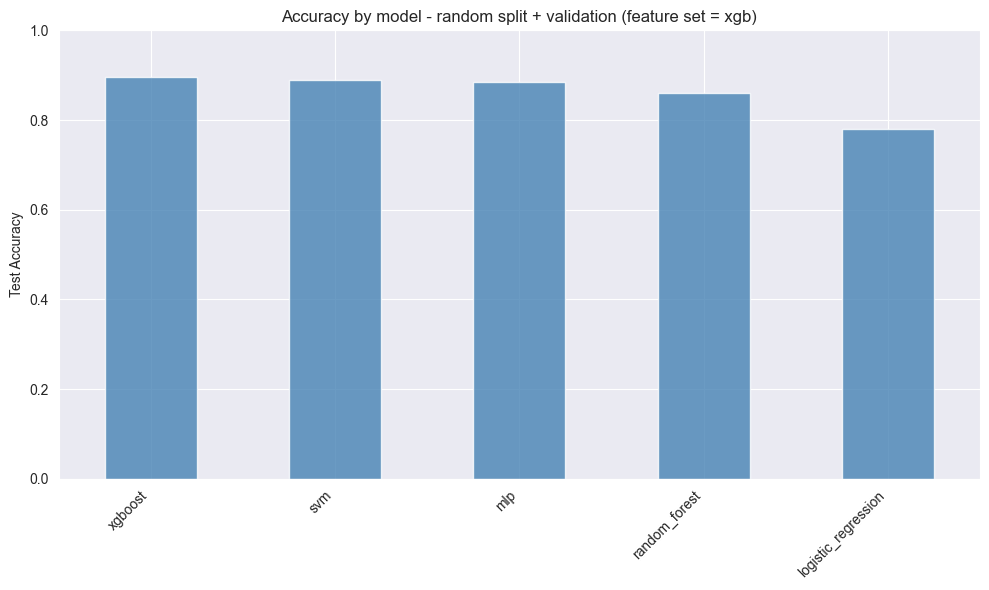

In [10]:
plt.figure(figsize=(10, 6))
summary["accuracy"].plot(kind="bar", color="steelblue", alpha=0.8)
plt.title(f"Accuracy by model - random split + validation (feature set = {FEATURE_SET})")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Best model (by validation accuracy): xgboost

Classification report:

                  precision    recall  f1-score   support

 air_conditioner       0.95      0.95      0.95       200
        car_horn       0.94      0.84      0.88        86
children_playing       0.86      0.89      0.87       200
        dog_bark       0.93      0.84      0.89       200
        drilling       0.86      0.88      0.87       200
   engine_idling       0.94      0.91      0.92       200
        gun_shot       0.86      0.99      0.92        75
      jackhammer       0.84      0.90      0.87       200
           siren       0.94      0.91      0.93       186
    street_music       0.85      0.88      0.87       200

        accuracy                           0.90      1747
       macro avg       0.90      0.90      0.90      1747
    weighted avg       0.90      0.90      0.90      1747



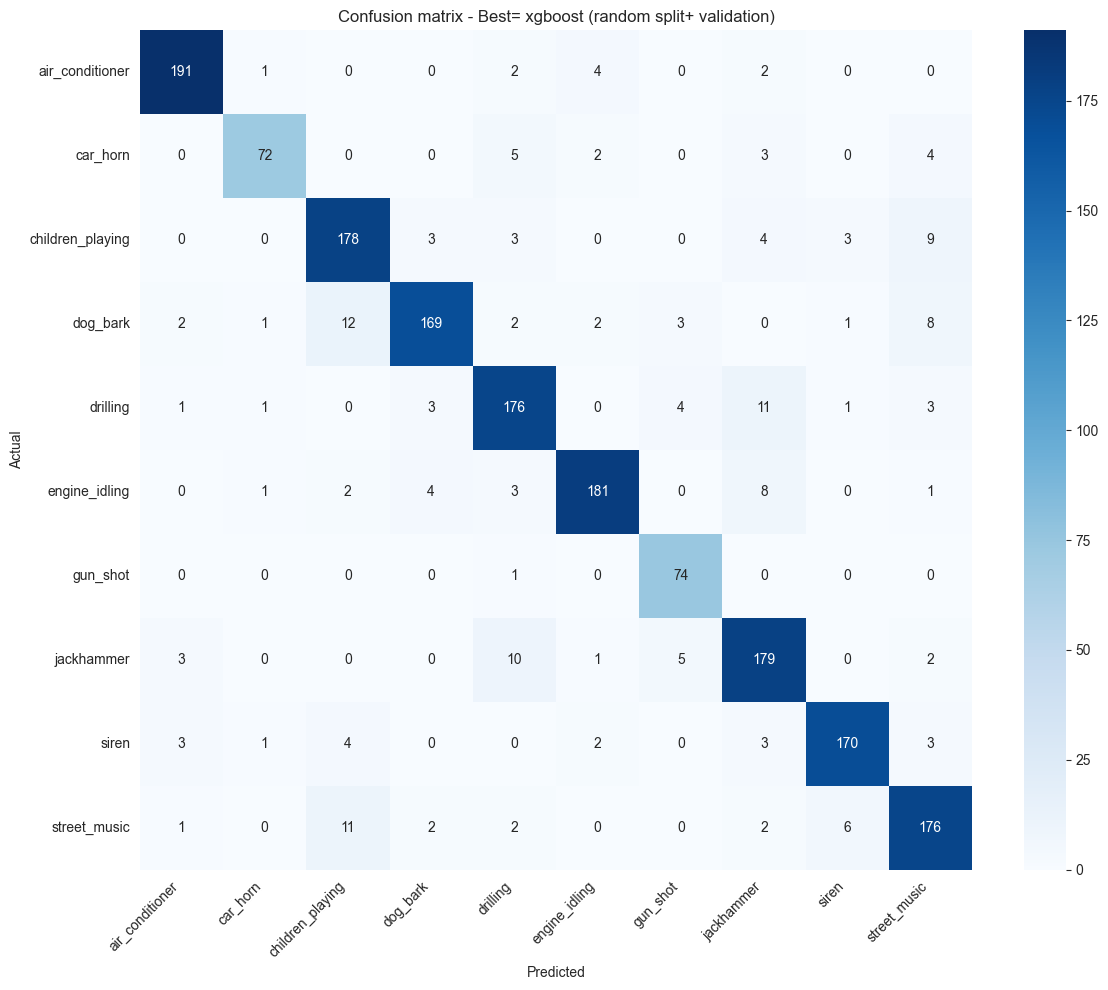

In [11]:
best_model_name = summary.index[0]
best_model = all_models[best_model_name]

print("Best model (by validation accuracy):", best_model_name)
best_model.fit(X_train_s, Y_train)
Y_pred_best = best_model.predict(X_test_s)

print("\nClassification report:\n")
print(classification_report(Y_test, Y_pred_best, target_names=config.CLASS_NAMES, zero_division=0))

cm = confusion_matrix(Y_test, Y_pred_best)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=config.CLASS_NAMES,
    yticklabels=config.CLASS_NAMES
)

plt.title(f"Confusion matrix - Best= {best_model_name} (random split+ validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()